## 1. Understand and distinguish these concepts:

*   **Sparsification** is the process of decreasing the number of edges in the network while maintaining some topological properties of the network. Edges are typically "decreased" by setting their weights equal to zero
*   **Pruning** is the process of removing edges from a network. It typically refers to setting a particular weight to 0 and freezing it for training. This is sometimes referred to as "applying a mask" to the weights
*   **Quantization** is the mapping of continous values (or otherwise very large set of values) to set of discrete values
*   **Distillation** is the process of transferring "knowledge" from a larger model to a smaller model. Logits, weights, or activations can be used as the source of "knowlege"
*   **MoEfication** (I was only able to find one paper referencing this: https://arxiv.org/pdf/2110.01786.pdf ) the transforming of a model to its MoE (Mixture of Experts) version via partitioning the internal network

## 2. Choose your models. Pick 3 models, 1 from each category. Each pick should be of more than 1B parameters before pruning.


*   Encoder-only: DeBERTa v2: 1.5B params (https://arxiv.org/abs/2006.03654; https://huggingface.co/microsoft/deberta-v2-xlarge) GLUE (CoLA, QQP, MNLI-m, SST-2, STS-B, QNLI, RTE, MRPC) MNLI-m, SQuAD, RACE, ReCoRD , SWAG, NER

*   Encoder-Decoder: (3B params) FLAN-T5 (https://huggingface.co/docs/transformers/model_doc/flan-t5, (GLUE, SQuAD, SuperGLUE, ...)

*   Decoder-only: GPT-2: 1.5B params (https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf; https://huggingface.co/gpt2) Benchmarks: LAMBADA, CBT-CN, CBT-NE, WikiText2, PTB, enwik8, text8, WikiText103, 1BW, WMT-14 English-French test set (and CoQA I think?)

In [2]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 13.4 MB/s 
     |████████████████████████████████| 163 kB 63.4 MB/s 
     |████████████████████████████████| 7.6 MB 51.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.5 MB/s 


### flan-t5

In [1]:
### Load in a model; have to do this one at a time b/c otherwise the session will crash due to out-of-ram
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

flan = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base") #flan-t5-large will cause out of ram. scale it down...
flan_tok = AutoTokenizer.from_pretrained("google/flan-t5-base")
inputs = flan_tok("A step by step recipe to make bolognese pasta:", return_tensors="pt")
outputs = flan.generate(**inputs)
print(flan_tok.batch_decode(outputs, skip_special_tokens=True))

Downloading:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/990M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/792k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['Preheat the oven to 375 degrees F. In a large bowl, combine the olive']


### gpt-2

In [ ]:
### Load in a model; have to do this one at a time b/c otherwise the session will crash due to out-of-ram
from transformers import GPT2Tokenizer, GPT2LMHeadModel

gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
gpt2_tok = GPT2Tokenizer.from_pretrained("gpt2")
inputs = gpt2_tok("A step by step recipe to make bolognese pasta:", return_tensors="pt")
outputs = gpt2.generate(**inputs)
print(gpt2_tok.batch_decode(outputs, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1364: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


['A step by step recipe to make bolognese pasta:\n\n1. Preheat oven']


### deberta

In [ ]:
### Load in a model; have to do this one at a time b/c otherwise the session will crash due to out-of-ram
#ref: https://huggingface.co/transformers/v4.7.0/model_doc/deberta_v2.html?highlight=forsequenceclassification
from transformers import DebertaV2Tokenizer, DebertaV2Model

debert = DebertaV2Model.from_pretrained("microsoft/deberta-v2-xlarge")
debert_tok = DebertaV2Tokenizer.from_pretrained("microsoft/deberta-v2-xlarge")
inputs = debert_tok("A step by step recipe to make bolognese pasta:", return_tensors="pt")
outputs = debert(**inputs)
last_hidden_states = outputs.last_hidden_state

Some weights of the model checkpoint at microsoft/deberta-v2-xlarge were not used when initializing DebertaV2Model: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### set model accordingly

In [2]:
model = flan #gpt2#debert #flan
tokenizer = flan_tok #gpt2_tok#debert_tok #flan_tok
modelName = "flan-t5" #"gpt-2"#"deberta v2" #"flan-t5"



## 3. Devise approaches to assess sparsity structure in your choice of models and answer these questiosn:

    what fraction of parameters >> 0? overall? by layer?
    how does this vary by layer?

Reference: https://stackoverflow.com/questions/67052427/how-to-access-a-particular-layer-of-huggingfaces-pre-trained-bert-model

https://stackoverflow.com/questions/54203451/how-to-iterate-over-layers-in-pytorch

In [1]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch, transformers

#for T5/Flan, deberta
#print(model.get_parameter)

thresh = 0.2

print("using the >> 0 cutoff of 0.2")
i = 0
totalNonzeroParams = 0
totalParams = 0
frac_nonzeroParams = []
for module in model.modules():
  #print(type(module))
  if isinstance(module, torch.nn.modules.linear.Linear) or isinstance(module, transformers.pytorch_utils.Conv1D):
    #print(f"i = {i} and this is a linear layer")
    layerNumParams = 0
    layerNonzero = 0
    weights = module.state_dict()['weight']
    for weight_vec in weights:
      for weight in weight_vec:
        if (abs(weight.item()) >= 0.2):
          layerNonzero += 1
          totalNonzeroParams += 1
        layerNumParams += 1
        totalParams += 1
        #break
      #break
    frac_nonzeroParams.append(layerNonzero / layerNumParams)
  i += 1
  '''if (i == 10):
    break
  '''
#print(i)
totalFracNonzero = totalNonzeroParams / totalParams
print(f"Evaluating model {modelName}\nTotal fraction of parameters >> 0? (overall) = {totalFracNonzero}")
print(f"Total fraction of parameters >> 0 (by layer), and how it varies by layer:")

print(frac_nonzeroParams)
x = range(0, len(frac_nonzeroParams))
y = frac_nonzeroParams
plt.title("Total fraction of parameters by layer:")
plt.plot(x, y)
plt.savefig("NonzeroParams_" + modelName + ".png")
plt.show()

using the >> 0 cutoff of 0.2


NameError: ignored

## 4. Produce sparsified versions of your models 

at 10%, 50%, 90%, 95%, 99%, by either coding your methods or using existing tools provided below.

Explain the nature of your methods, regardless of whether you code it yourselves.

**Explanation of my methods:**
I will use the existing tool of Pytorch Prune. I will specifically use global pruning, which, given the layers to prune, will prune weights by "removing" (setting = 0) the lowest (in abs magnitude) x% of weights over the model globally, where x is specified by the programmer. Since weights are pruned in a global manner, there may be more or less than x% of weights pruned per layer, however, x% of weights will be pruned over the entire ("global") model.

In [2]:
#ref, existing tools: https://oaklight.github.io/dls2022/
import transformers, torch
import torch.nn.utils.prune as prune

#make a list of the layers to globally prune.
#returns a list 
def getParamsToPrune(unpruned_model):
  tupList = []
  for module in unpruned_model.modules():
    if isinstance(module, torch.nn.modules.linear.Linear) or isinstance(module, transformers.pytorch_utils.Conv1D):
      tupList.append((module, "weight"))

  parameters_to_prune = tuple(tupList)
  return parameters_to_prune

#conveience function. Prunes a model
def pruneModel(unpruned_model, prune_percent):
  #get params to prune
  params_to_prune = getParamsToPrune(unpruned_model)  

  #prune
  prune.global_unstructured(
      params_to_prune,
      pruning_method=prune.L1Unstructured,
      amount=prune_percent,
  )

  #make pruning permanent
  for module in unpruned_model.modules():
    if isinstance(module, torch.nn.modules.linear.Linear) or isinstance(module, transformers.pytorch_utils.Conv1D):
      prune.remove(module, 'weight')

  return unpruned_model



In [62]:
#!pip install transformers
from transformers import AutoModelForSeq2SeqLM
#from transformers import GPT2LMHeadModel
#from transformers import DebertaV2Model
#from transformers import DebertaForMaskedLM

In [78]:
pruning_percentages = [0.1, 0.5, 0.9, 0.95, 0.99]
pruning_percent = 0.1

#conveinence fun
def getFreshModel():
  thismodel = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small") #flan-t5-large, flan-t5-base will cause out of ram during global pruning :(
  #thismodel = GPT2LMHeadModel.from_pretrained("gpt2")
  #thismodel = DebertaV2Model.from_pretrained("microsoft/deberta-v2-xlarge") #microsoft/deberta-v2-xlarge crashes due to out of ram... and so far, only the sizes xlarge, xxlarge have been released
  #thismodel = DebertaForMaskedLM.from_pretrained("microsoft/deberta-base") #deberta large crashed...
  return thismodel

pruned = getFreshModel()#pruneModel(getFreshModel(), pruning_percent) #getFreshModel()#

## 5. Find 2 common benchmarks used by your models, by reviewing their publications.

Set them up and obtain baseline results of original models.

Compare performance of your sparsified versions with the baselines. Include plots and explanations.


---

GPT-2 has no benchmarks in common with FLAN-T5 or DeBERTa v2. FLAN-T5 and DeBERTa have some benchmarks in common, since they report accuracy on both the SQUAD and GLUE benchmark suite. However, FLAN-T5 appears to only be available in a form which supports conditional generation, summarization, and translation. None of these tasks are compatible with the contents of the SQUAD or GLUE benchmark suites. (See: https://huggingface.co/docs/transformers/model_doc/t5, https://github.com/google-research/text-to-text-transfer-transformer). I was originally going to fine-tune FLAN-T5 to work on sentiment analysis despite this, however further research indicated this would be a time consuming and non-trivial task--see https://colab.research.google.com/github/enzoampil/t5-intro/blob/master/t5_qa_training_pytorch_span_extraction.ipynb . I include the code that I drafted as part of fine tuning to indicate that I have spent substantial effort attempting to benchmark FLAN-T5.


---


Due to these logistical issues, I instead choose to benchmark all three models using benchmarks from the GPT-2 paper: perplexity on wikitext-2, and wikitext-103. I thank the teaching staff for their understanding regarding this decision.



(perplexity reference: https://huggingface.co/docs/transformers/main/en/perplexity and https://huggingface.co/docs/evaluate/main/en/types_of_evaluations)


## Benchmarking, wikitext-2, wikitext-103

In [79]:
from datasets import load_dataset
from transformers import AutoTokenizer

pruned = pruned.to("cuda")

test = load_dataset("wikitext", "wikitext-103-raw-v1", split="test") #"wikitext-2-raw-v1"
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")


Token indices sequence length is longer than the specified maximum sequence length for this model (338498 > 512). Running this sequence through the model will result in indexing errors


In [80]:
#%%time is kind of redundant given we use tqdm but whatever
%%time

#note--this code borrows heavily from sample code on calculating perplexity from huggingface
import torch
from tqdm import tqdm


##deberta doesn't have a config.n_positions; it has config.max_position_embeddings instead
#max_length = pruned.config.max_position_embeddings
max_length = pruned.config.n_positions
stride = 512 #use a "sliding window"--this leads to more accurate calculation of perpelxity
seq_len = encodings.input_ids.size(1)

nlls = []
prev_end_loc = 0
for begin_loc in tqdm(range(0, seq_len, stride)):
    end_loc = min(begin_loc + max_length, seq_len)
    trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
    input_ids = encodings.input_ids[:, begin_loc:end_loc].to("cuda")
    target_ids = input_ids.clone()
    target_ids[:, :-trg_len] = -100

    with torch.no_grad():
        outputs = pruned(input_ids, labels=target_ids)
        #loss is calculated as CrossEntropy, which averages. Multiplying by trg_len will give us the sum
        neg_log_likelihood = outputs.loss * trg_len 

    nlls.append(neg_log_likelihood)

    prev_end_loc = end_loc
    if end_loc == seq_len:
        break

ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
print(f"\nperplexity: {ppl}")


100%|█████████▉| 661/662 [00:32<00:00, 20.52it/s]


perplexity: 1.2162978649139404
CPU times: user 23 s, sys: 153 ms, total: 23.1 s
Wall time: 32.2 s


In [81]:
#this information is gained through multiple, manual runs; only one model can be loaded at a time
#before the session crashes due to out of ram errors.
pruning = [0, 0.1, 0.5, 0.9, 0.95, 0.99]

t5_perplex_wiki2 = [1.216, 1.36584, 3889.304, 742372480, 119479776, 780557.9375]
t5_time_wiki2 = [21.5, 21.2, 20.8, 19.7, 20.5, 19.5] #in seconds

t5_perplex_wiki103 = [1.216, 1.3658, 3889.304, 742372480.0, 119479776.0, 780557.9375]
t5_time_wiki103 = [23, 23.2, 21.9, 21.3, 20.9, 20.7]

gpt2_perplex_wiki2 = [25.17, 25.4695, 4441.9663, 5592.688, 6712.307, 14462.59375]
gpt2_time_wiki2 = [60, 59.8, 58.3, 59.8, 62, 58.9]

gpt2_perplex_wiki103 = [25.1704, 25.4695, 4441.9663, 5592.688, 6712.3071, 14462.5938]
gpt2_time_wiki103 = [67, 68, 66, 63, 62, 60]

debert_perplex_wiki2 = [86827.46875, 102949.7188, 96568, 83758.0547, 58738.4727, 50265.0195]
debert_time_wiki2 = [46.5, 48.9 , 48.2, 43.6, 40.8, 40.7]

debert_perplex_wiki103 = [91603.9766, 134817.5938, 94428.6563, 80109.9844, 73871.8281, 50265.0195]
debert_time_wiki103 = [48.7, 48.8, 47.4, 45.8, 45.1, 42.6]

In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 33.0 MB/s 
     |████████████████████████████████| 7.6 MB 44.9 MB/s 
     |████████████████████████████████| 163 kB 44.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 441 kB 32.4 MB/s 
     |████████████████████████████████| 95 kB 5.2 MB/s 
     |████████████████████████████████| 212 kB 71.0 MB/s 
     |████████████████████████████████| 115 kB 68.3 MB/s 
     |████████████████████████████████| 127 kB 63.9 MB/s 
     |████████████████████████████████| 115 kB 66.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully un

##6. Compare size of models and runtime for sparsified models. 

Include plots and explanations.

Runtime in this context means "time to compute baseline" here.

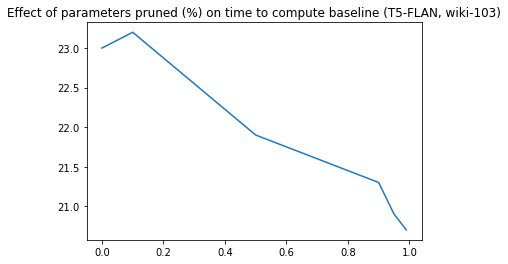

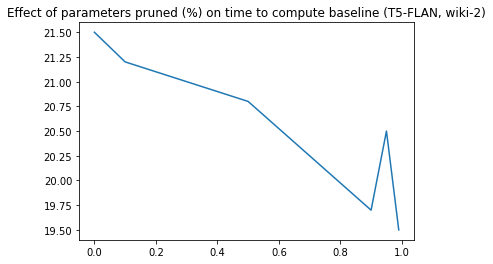

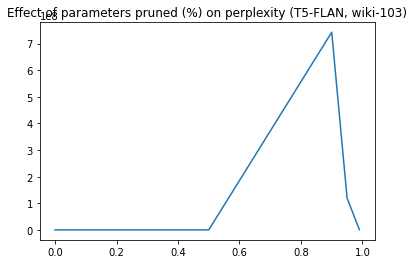

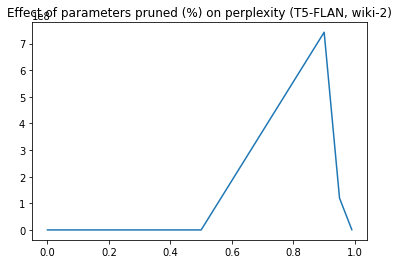

In [86]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

x = pruning
y = t5_time_wiki103
plt.title("Effect of parameters pruned (%) on time to compute baseline (T5-FLAN, wiki-103)")
plt.plot(x, y)
plt.savefig("t5_time_103.png")
plt.show()

y = t5_time_wiki2
plt.title("Effect of parameters pruned (%) on time to compute baseline (T5-FLAN, wiki-2)")
plt.plot(x, y)
plt.savefig("t5_time_2.png")
plt.show()

y = t5_perplex_wiki103
plt.title("Effect of parameters pruned (%) on perplexity (T5-FLAN, wiki-103)")
plt.plot(x, y)
plt.savefig("t5_perplex_103.png")
plt.show()

y = t5_perplex_wiki2
plt.title("Effect of parameters pruned (%) on perplexity (T5-FLAN, wiki-2)")
plt.plot(x, y)
plt.savefig("t5_perplex_2.png")
plt.show()

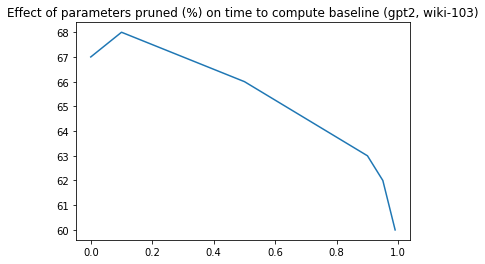

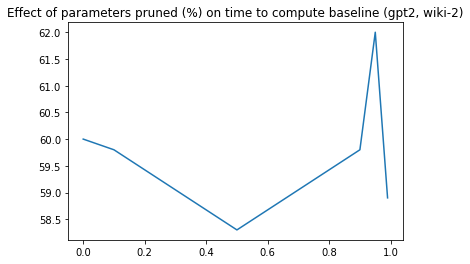

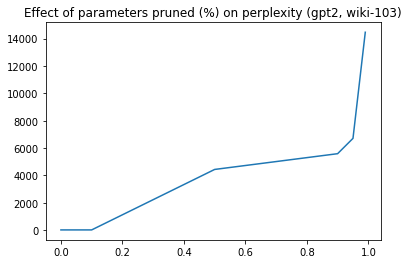

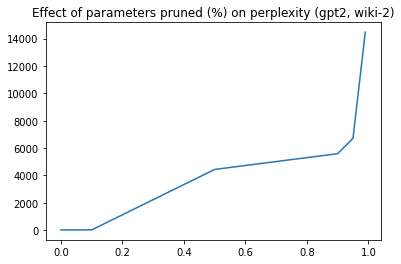

In [87]:
x = pruning
y = gpt2_time_wiki103
plt.title("Effect of parameters pruned (%) on time to compute baseline (gpt2, wiki-103)")
plt.plot(x, y)
plt.savefig("gpt2_time_103.png")
plt.show()

y = gpt2_time_wiki2
plt.title("Effect of parameters pruned (%) on time to compute baseline (gpt2, wiki-2)")
plt.plot(x, y)
plt.savefig("gpt2_time_2.png")
plt.show()

y = gpt2_perplex_wiki103
plt.title("Effect of parameters pruned (%) on perplexity (gpt2, wiki-103)")
plt.plot(x, y)
plt.savefig("gpt2_perplex_103.png")
plt.show()

y = gpt2_perplex_wiki2
plt.title("Effect of parameters pruned (%) on perplexity (gpt2, wiki-2)")
plt.plot(x, y)
plt.savefig("gpt2_perplex_2.png")
plt.show()

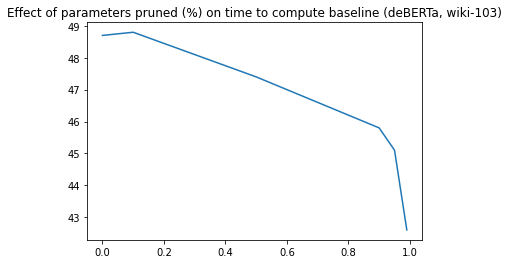

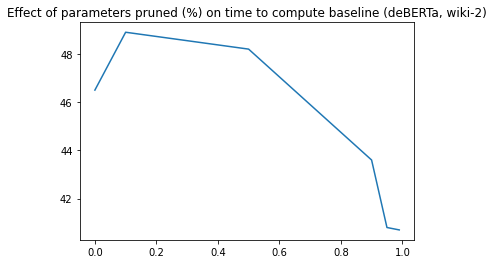

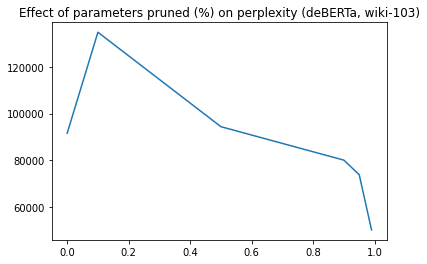

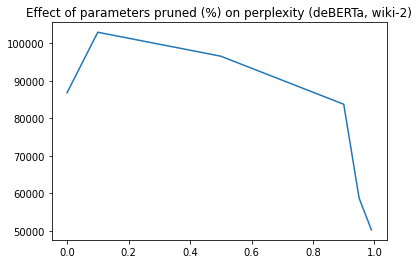

In [88]:
x = pruning
y = debert_time_wiki103
plt.title("Effect of parameters pruned (%) on time to compute baseline (deBERTa, wiki-103)")
plt.plot(x, y)
plt.savefig("debert_time_103.png")
plt.show()

y = debert_time_wiki2
plt.title("Effect of parameters pruned (%) on time to compute baseline (deBERTa, wiki-2)")
plt.plot(x, y)
plt.savefig("debert_time_2.png")
plt.show()

y = debert_perplex_wiki103
plt.title("Effect of parameters pruned (%) on perplexity (deBERTa, wiki-103)")
plt.plot(x, y)
plt.savefig("debert_perplex_103.png")
plt.show()

y = debert_perplex_wiki2
plt.title("Effect of parameters pruned (%) on perplexity (deBERTa, wiki-2)")
plt.plot(x, y)
plt.savefig("debert_perplex_2.png")
plt.show()

## 7. Explain the challenges of sparsification on LLMs.

I found the main challenges to be:

1. The computational cost of sparsification
2. Performance does not degrade linearly as sparsification occurs, making it difficult to determine exactly to what degree one should sparsify a model
3. Given multiple weights which are candidates for pruning, it is typically not clear which weights should be pruned over others. That is, it will become clear after benchmarking/other experimentation, however benchmarking, experimentation is time consuming.
4. Computational time for inference does not decrease linearly as sparsification occurs. I found in my experiments that there was a lot of "noise" in my observed measurements. This similarly makes it harder to gauge the exact benefits of sparsification.



# Unused: code written to finetune T5-Flan for benchmarking

In [10]:
from google.colab import drive

drive.mount("content/")

#save_path = "/content/content/MyDrive/Colab Notebooks/llm_assignments/asst4-sparsification/fine_tuned/t5"

thismodel = AutoModelForSequenceClassification.from_pretrained("google/flan-t5-base", num_labels=2)

Mounted at content/


In [14]:
tok_path = "/content/content/MyDrive/Colab Notebooks/llm_assignments/asst4-sparsification/fine_tuned/t5/tok"
train_path = "/content/content/MyDrive/Colab Notebooks/llm_assignments/asst4-sparsification/fine_tuned/t5/sst2_train"
test_path = "/content/content/MyDrive/Colab Notebooks/llm_assignments/asst4-sparsification/fine_tuned/t5/sst2_test"

In [18]:
from datasets import load_dataset
from transformers import AutoTokenizer

test = load_dataset("sst2", split="test")
train = load_dataset("sst2", split="train")

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

def tokenize_function(an_example):
    return tokenizer(an_example["sentence"], padding="max_length", truncation=True)

test_tok = test.map(tokenize_function, batched=True)
train_tok = train.map(tokenize_function, batched=True)

tokenizer.save_pretrained(tok_path)
train_tok.save_to_disk(train_path)
test_tok.save_to_disk(test_path)

loading file spiece.model from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/98d18233b7e132ba1ba04e47fb056ecf913623fe/spiece.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/98d18233b7e132ba1ba04e47fb056ecf913623fe/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/98d18233b7e132ba1ba04e47fb056ecf913623fe/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--flan-t5-base/snapshots/98d18233b7e132ba1ba04e47fb056ecf913623fe/tokenizer_config.json


  0%|          | 0/68 [00:00<?, ?ba/s]

tokenizer config file saved in /content/content/MyDrive/Colab Notebooks/llm_assignments/asst4-sparsification/fine_tuned/t5/tok/tokenizer_config.json
Special tokens file saved in /content/content/MyDrive/Colab Notebooks/llm_assignments/asst4-sparsification/fine_tuned/t5/tok/special_tokens_map.json


In [ ]:
from datasets.load import load_from_disk

tok_train = load_from_disk(train_path)
tok_test = load_from_disk(test_path)
tokenizer = AutoTokenizer.from_pretrained(tok_path)

In [28]:
#!python -c "import evaluate; print(evaluate.load('exact_match').compute(references=['hello'], predictions=['hello']))"
import transformers
from transformers import TrainingArguments, Trainer, AutoTokenizer, DataCollatorForLanguageModeling

pruned = pruned.to("cuda")

data_collator = DataCollatorForLanguageModeling(
  tokenizer=tokenizer,
  mlm=False,
)

training_args = TrainingArguments(
    output_dir="/content/content/MyDrive/Colab Notebooks/llm_assignments/asst4-sparsification/fine_tuned/t5/sst2_0",
    per_device_train_batch_size=4
    )

trainer = Trainer(
    model=pruned,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tok_train,
    eval_dataset=tok_test,
)

trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: idx, sentence. If idx, sentence are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 67349
  Num Epochs = 3
  Instantaneous batch size per device = 4
  Total train bat

TypeError: ignored

In [34]:
test[0]
print(tok_test[0])
predictions = trainer.predict(tok_test["input_ids"])
print(predictions.predictions.shape, predictions.label_ids.shape)

{'idx': 0, 'sentence': 'uneasy mishmash of styles and genres .', 'label': -1, 'input_ids': [73, 20905, 1817, 107, 51, 3198, 13, 4634, 11, 5349, 7, 3, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

***** Running Prediction *****
  Num examples = 1821
  Batch size = 8


AttributeError: ignored

In [ ]:

''' Session will crash due to out of ram if we try and prune multiple models in one go
pruned_models = []

pruned_models.append(getFreshModel())
print(f"Loaded fresh model")

for elem in pruning_percentages:
  pruning_percent = elem
  fresh = getFreshModel()
  pruned_models.append(pruneModel(fresh, pruning_percent))
  print(f"Successfully pruned model at {pruning_percent} pruned")

#pruned models now contains a list of models pruned at 0%, 10%, 50%, 90%, 95%, 99%.
'''